# Example: Regenerating Data from
# [R. Wu et al. / Elec Acta 54 25 (2010) 7394–7403](http://www.sciencedirect.com/science/article/pii/S0013468610009503)

Import the modules

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import openpnm.models.geometry as gm
import openpnm.topotools as tt
%matplotlib inline

C:\Users\Tom\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Set the workspace loglevel to not print anything

In [2]:
wrk = op.Workspace()
wrk.loglevel=50

Custom function to take the results of the percolation algorithm and update phase occupancy

In [3]:
def update_occupancy(res, phase, p_map, t_map):
    phase['pore.occupancy'] = 1 - res['pore.occupancy'][p_map]
    phase['throat.occupancy'] = 1 - res['throat.occupancy'][t_map]

Custom function to calculate an effective transport property using network dimensions that are not calculated from the B.C's as per the standard openpnm function

In [4]:
def _calc_eff_prop(self):
    r"""
    Returns the main parameters for calculating the effective property
    in a linear transport equation.  It also checks for the proper
    boundary conditions, inlets and outlets.
    """
    if self.settings['quantity'] not in self.keys():
        raise Exception('The algorithm has not been run yet. Cannot ' +
                        'calculate effective property.')

    # Determine boundary conditions by analyzing algorithm object
    inlets, outlets = self._get_inlets_and_outlets()
    Ps = np.isfinite(self['pore.bc_value'])
    BCs = np.unique(self['pore.bc_value'][Ps])
    Dx = np.abs(np.diff(BCs))
    net = self.project.network
    # Fetch area and length of domain
    [amax, bmax, cmax] = np.max(net['pore.coords'], axis=0)
    [amin, bmin, cmin] = np.min(net['pore.coords'], axis=0)
    lx = amax-amin
    ly = bmax-bmin
    lz = cmax-cmin
    A = lx*ly
    L = lz
    flow = self.rate(pores=inlets)
    D = np.sum(flow)*L/A/Dx
    return D

Wu's diffusive conductance model

In [5]:
def bulk_diffusion_wu(physics,
                      network,
                      phase,
                      geometry,
                      propname,
                      diffusivity = 'pore.diffusivity',
                      molar_density = 'pore.molar_density',
                      throat_diameter = 'throat.diameter',
                      throat_length = 'throat.length',
                      pore_diameter = 'pore.diameter',
                      **params):
        r"""
        Calculate the diffusive conductance of throats in network (instead of a
        conduit) based on the areas

        Parameters
        ----------
        network : OpenPNM Network Object

        phase : OpenPNM Phase Object
        The phase of interest

        Notes
        -----
        This function requires that all the necessary phase properties already be
        calculated.

        """
        #ct = phase.get_data(prop='molar_density',throats='all',mode='interpolate')
        #Interpolate pore values to throats
        DABt = phase.interpolate_data(propname='pore.diffusivity')
        #Find g for full throat
        tdia = network[throat_diameter]
        tlen = network[throat_length]
        gt = (sp.pi*DABt*tdia**2)/(tlen*4)
        g = gt[geometry.throats()]
        phase[propname]=g

A function to run the simulation for a given network size 'n' and number of points for the relative diffusivity curve. Setting 'npts' to 1 will return the single phase diffusivity. the network size is doubled in the z direction for percolation but the diffusion calculation is effectively only calculated on the middle square section of length 'n'. This is achieved by copying the saturation distribution from the larger network to a smaller one.

In [6]:
def simulation(n=8, npts=51):
    print('*'*60)
    print('Running Sim with Net Size =', n, 'num points', npts)
    print('*'*60)
    Lc = 25e-6
    pn1 = op.network.Cubic(shape=[n,n,2*n], spacing=Lc)
    #code to run if boundaries was set to false
    Ps = pn1.pores()
    Ts = pn1.throats()
    geo1 = op.geometry.GenericGeometry(network=pn1, pores=Ps,throats=Ts)
    
    low = .5e-6
    high = 9.5e-6
    
    geo1['pore.diameter'] = 24e-6
    radii = low + sp.rand(pn1.num_throats())*(high - low)
    geo1['throat.diameter'] = radii*2
    geo1.add_model(propname='pore.volume', model=gm.pore_volume.sphere)
    geo1.add_model(propname='pore.area', model=gm.pore_area.sphere)
    geo1.add_model(propname='throat.length', model=gm.throat_length.straight)
    geo1.add_model(propname='throat.volume', model=gm.throat_volume.cylinder)
    geo1.add_model(propname='throat.area', model=gm.throat_area.cylinder)
    

    water = op.phases.Water(network = pn1)
    Ps = geo1.pores()
    Ts = geo1.throats()
    phys_water = op.physics.Standard(network=pn1, phase=water, geometry=geo1)
    IP_1 = op.algorithms.InvasionPercolation(network=pn1)
    IP_1.setup(phase=water)
    inlets = pn1.pores('bottom')
    IP_1.set_inlets(pores=inlets)
    IP_1.run()

    z_vals = np.unique(pn1['pore.coords'][:, 2])[int(n/2):int(3*n/2)]
    pore_map = np.in1d(pn1['pore.coords'][:, 2], z_vals)
    throat_map = pn1.find_neighbor_throats(pn1.pores()[pore_map], mode='intersection')
    pn2 = op.network.Cubic(shape=[n,n,n], spacing=Lc)
    prj2 = pn2.project
    Ps = pn2.pores()
    Ts = pn2.throats()
    geo2 = op.geometry.GenericGeometry(network=pn2, pores=Ps, throats=Ts)
    for prop in geo1.props():
        if 'pore' in prop:
            geo2[prop] = geo1[prop][pore_map]
        else:
            geo2[prop] = geo1[prop][throat_map]
        
    air = op.phases.Air(network = pn2)
    phys_air = op.physics.Standard(network=pn2, phase=air, geometry=geo2)
    del phys_air['throat.diffusive_conductance']
    bulk_diffusion_wu(physics = phys_air, network=pn2, phase=air, geometry=geo2, propname='throat.diffusive_conductance')
    phys_water.regenerate_models()
    phys_air.regenerate_models()

    x_values = []
    y_values = []
    
    res = IP_1.results(0.0)
    update_occupancy(res, air, pore_map, throat_map)
    phys_air.add_model(model=op.models.physics.multiphase.conduit_conductance,
                       propname='throat.conduit_diffusive_conductance',
                       throat_conductance='throat.diffusive_conductance',
                       mode='strict')
    bulk_diffusivity = air['pore.diffusivity']
    bottom_boundary = pn2['pore.bottom']
    top_boundary = pn2['pore.top']

    for x in range(npts):
        IPsat = float(x)/float(npts)
        res = IP_1.results(IPsat)
        update_occupancy(res, air, pore_map, throat_map)
        phys_air.regenerate_models(propnames=['throat.conduit_diffusive_conductance'])
        mask = air['throat.conduit_diffusive_conductance'] == air['throat.diffusive_conductance']
        am = pn2.create_adjacency_matrix(weights=mask, fmt='coo')
        if tt.ispercolating(am,
                            bottom_boundary,
                            top_boundary,
                            'bond'):
            print('Step', x, 'is percolating')
            Fickian_alg = op.algorithms.FickianDiffusion(network=pn2, phase=air)
            Fickian_alg.set_value_BC(values=0.6, pores=top_boundary)
            Fickian_alg.set_value_BC(values=0.2, pores=bottom_boundary)
            Fickian_alg.setup(conductance='throat.conduit_diffusive_conductance')
            Fickian_alg.run()
            effective_diffusivity = _calc_eff_prop(Fickian_alg)/np.mean(air['pore.molar_density'])
            prj2.purge_object(Fickian_alg)
        else:
            print('Step', x, 'is NOT percolating')
            effective_diffusivity = 1e-12
        #calculation of saturation
        p_vol = pn2['pore.volume']
        saturation = 1 - np.sum(air['pore.occupancy']*p_vol)/np.sum(p_vol)
        Deff = (effective_diffusivity/bulk_diffusivity)[0]
        print('Step', x, 'Saturation', "%.3f" % saturation, 'Diffusivity', "%.3f" % Deff)
        x_values.append(saturation)
        y_values.append(Deff)

    return x_values, y_values

Run the simulation once for a network of size 8 x 8 x 8

In [7]:
x_values, y_values = simulation(n=8)

************************************************************
Running Sim with Net Size = 8 num points 51
************************************************************
Step 0 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 90.72307390170116
Solution converged: 0.0
Step 0 Saturation 0.000 Diffusivity 0.100
Step 1 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 90.72307390170116
Solution converged: 0.0
Step 1 Saturation 0.000 Diffusivity 0.100
Step 2 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 90.72307390170116
Solution converged: 0.0
Step 2 Saturation 0.000 Diffusivity 0.100
Step 3 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 83.82080860641847
Solution converged: 0.0
Step 34 Saturation 0.691 Diffusivity 0.007
Step 35 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 83.34156200707227
Solution converged: 0.0
Step 35 Saturation 0.707 Diffusivity 0.007
Step 36 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 83.32345991646478
Solution converged: 0.0
Step 36 Saturation 0.723 Diffusivity 0.007
Step 37 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 85.31994201259009
Solution converged: 0.0
Step 37 Saturation 0.736 Diffusivity 0.007
Step 38 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

************************************************************
Running Sim with Net Size = 8 num points 51
************************************************************
Step 0 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 88.03088407505672
Solution converged: 0.0
Step 0 Saturation 0.000 Diffusivity 0.098
Step 1 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 88.03088407505672
Solution converged: 0.0
Step 1 Saturation 0.000 Diffusivity 0.098
Step 2 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 88.03088407505672
Solution converged: 0.0
Step 2 Saturation 0.000 Diffusivity 0.098
Step 3 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 93.33947743476111
Solution converged: 0.0
Step 34 Saturation 0.686 Diffusivity 0.010
Step 35 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 88.85657032852306
Solution converged: 0.0
Step 35 Saturation 0.715 Diffusivity 0.006
Step 36 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 91.60979766446499
Solution converged: 0.0
Step 36 Saturation 0.742 Diffusivity 0.004
Step 37 is NOT percolating
Step 37 Saturation 0.781 Diffusivity 0.000
Step 38 is NOT percolating
Step 38 Saturation 0.812 Diffusivity 0.000
Step 39 is NOT percolating
Step 39 Saturation 0.830 Diffusivity 0.000
Step 40 is NOT percolating
Step 40 Saturation 0.844 Diffusivity 0.000
Step 41 is NOT percolating
Step 41 Satura

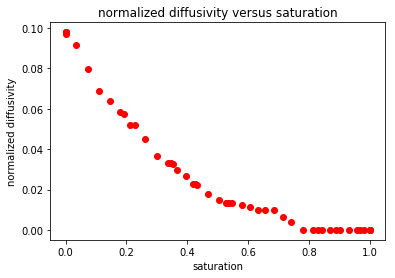

In [8]:
x_values, y_values = simulation(n=8)
plt.figure()
plt.plot(x_values, y_values, 'ro')
plt.title('normalized diffusivity versus saturation')
plt.xlabel('saturation')
plt.ylabel('normalized diffusivity')
plt.show()

We can run multiple times as the network sizes are randomly generated between a given range we can obtain an average

In [9]:
x_values = []
y_values = []

for ensemble in range(10):
    x_ensemble, y_ensemble = simulation(n=8)
    x_values.append(x_ensemble)
    y_values.append(y_ensemble)

************************************************************
Running Sim with Net Size = 8 num points 51
************************************************************
Step 0 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 89.22105981217302
Solution converged: 0.0
Step 0 Saturation 0.000 Diffusivity 0.096
Step 1 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 89.22105981217302
Solution converged: 0.0
Step 1 Saturation 0.000 Diffusivity 0.096
Step 2 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 89.22105981217302
Solution converged: 0.0
Step 2 Saturation 0.000 Diffusivity 0.096
Step 3 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance

Step 35 is NOT percolating
Step 35 Saturation 0.777 Diffusivity 0.000
Step 36 is NOT percolating
Step 36 Saturation 0.787 Diffusivity 0.000
Step 37 is NOT percolating
Step 37 Saturation 0.816 Diffusivity 0.000
Step 38 is NOT percolating
Step 38 Saturation 0.842 Diffusivity 0.000
Step 39 is NOT percolating
Step 39 Saturation 0.842 Diffusivity 0.000
Step 40 is NOT percolating
Step 40 Saturation 0.854 Diffusivity 0.000
Step 41 is NOT percolating
Step 41 Saturation 0.883 Diffusivity 0.000
Step 42 is NOT percolating
Step 42 Saturation 0.896 Diffusivity 0.000
Step 43 is NOT percolating
Step 43 Saturation 0.920 Diffusivity 0.000
Step 44 is NOT percolating
Step 44 Saturation 0.936 Diffusivity 0.000
Step 45 is NOT percolating
Step 45 Saturation 0.953 Diffusivity 0.000
Step 46 is NOT percolating
Step 46 Saturation 0.973 Diffusivity 0.000
Step 47 is NOT percolating
Step 47 Saturation 0.982 Diffusivity 0.000
Step 48 is NOT percolating
Step 48 Saturation 1.000 Diffusivity 0.000
Step 49 is NOT perco

Step 30 Saturation 0.633 Diffusivity 0.000
Step 31 is NOT percolating
Step 31 Saturation 0.643 Diffusivity 0.000
Step 32 is NOT percolating
Step 32 Saturation 0.650 Diffusivity 0.000
Step 33 is NOT percolating
Step 33 Saturation 0.684 Diffusivity 0.000
Step 34 is NOT percolating
Step 34 Saturation 0.719 Diffusivity 0.000
Step 35 is NOT percolating
Step 35 Saturation 0.740 Diffusivity 0.000
Step 36 is NOT percolating
Step 36 Saturation 0.754 Diffusivity 0.000
Step 37 is NOT percolating
Step 37 Saturation 0.771 Diffusivity 0.000
Step 38 is NOT percolating
Step 38 Saturation 0.805 Diffusivity 0.000
Step 39 is NOT percolating
Step 39 Saturation 0.820 Diffusivity 0.000
Step 40 is NOT percolating
Step 40 Saturation 0.844 Diffusivity 0.000
Step 41 is NOT percolating
Step 41 Saturation 0.863 Diffusivity 0.000
Step 42 is NOT percolating
Step 42 Saturation 0.889 Diffusivity 0.000
Step 43 is NOT percolating
Step 43 Saturation 0.910 Diffusivity 0.000
Step 44 is NOT percolating
Step 44 Saturation 0

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 115.51641636377843
Solution converged: 0.0
Step 28 Saturation 0.633 Diffusivity 0.003
Step 29 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 112.78859229372335
Solution converged: 0.0
Step 29 Saturation 0.650 Diffusivity 0.001
Step 30 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 108.70443851926177
Solution converged: 0.0
Step 30 Saturation 0.686 Diffusivity 0.001
Step 31 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 108.58999874391688
Solution converged: 0.0
Step 31 Saturation 0.695 Diffusivity 0.001
Step 32 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Step 24 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 102.57774445782417
Solution converged: 0.0
Step 24 Saturation 0.406 Diffusivity 0.030
Step 25 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 101.68680463807983
Solution converged: 0.0
Step 25 Saturation 0.414 Diffusivity 0.029
Step 26 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 102.77146179629753
Solution converged: 0.0
Step 26 Saturation 0.455 Diffusivity 0.023
Step 27 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 98.57748727905576
Solution converged: 0.0
Step 27 Saturation 0.486 Diffusivity 0.019
Step 28 is percolating
――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 103.05339146591388
Solution converged: 0.0
Step 19 Saturation 0.393 Diffusivity 0.019
Step 20 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 111.53520490591893
Solution converged: 0.0
Step 20 Saturation 0.432 Diffusivity 0.012
Step 21 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 111.30526924857914
Solution converged: 0.0
Step 21 Saturation 0.445 Diffusivity 0.011
Step 22 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 110.13127633762028
Solution converged: 0.0
Step 22 Saturation 0.463 Diffusivity 0.011
Step 23 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Step 12 Saturation 0.277 Diffusivity 0.046
Step 13 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 95.97332005064501
Solution converged: 0.0
Step 13 Saturation 0.316 Diffusivity 0.040
Step 14 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 91.1463496362534
Solution converged: 0.0
Step 14 Saturation 0.348 Diffusivity 0.036
Step 15 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 90.40420975546083
Solution converged: 0.0
Step 15 Saturation 0.355 Diffusivity 0.035
Step 16 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 90.40420975546083
Solution converged: 0.0
Step 16 Saturation 0.355 Diffusivity 0.035
Step 17 is percolating

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 96.18066857685415
Solution converged: 0.0
Step 7 Saturation 0.127 Diffusivity 0.070
Step 8 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 98.50907370016023
Solution converged: 0.0
Step 8 Saturation 0.164 Diffusivity 0.064
Step 9 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 98.99929249708737
Solution converged: 0.0
Step 9 Saturation 0.178 Diffusivity 0.061
Step 10 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 97.8704905362182
Solution converged: 0.0
Step 10 Saturation 0.191 Diffusivity 0.059
Step 11 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Solution converged: 0.0
Step 3 Saturation 0.000 Diffusivity 0.098
Step 4 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 96.50236913595731
Solution converged: 0.0
Step 4 Saturation 0.029 Diffusivity 0.090
Step 5 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 97.65978446299428
Solution converged: 0.0
Step 5 Saturation 0.041 Diffusivity 0.088
Step 6 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 98.85554837286722
Solution converged: 0.0
Step 6 Saturation 0.051 Diffusivity 0.086
Step 7 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 102.52871115771569
Solution converged: 0.0
Step 7 Saturation 0.090 Diffusivity 0.076
Step 

Solution converged: 0.0
Step 38 Saturation 0.793 Diffusivity 0.000
Step 39 is NOT percolating
Step 39 Saturation 0.818 Diffusivity 0.000
Step 40 is NOT percolating
Step 40 Saturation 0.830 Diffusivity 0.000
Step 41 is NOT percolating
Step 41 Saturation 0.844 Diffusivity 0.000
Step 42 is NOT percolating
Step 42 Saturation 0.879 Diffusivity 0.000
Step 43 is NOT percolating
Step 43 Saturation 0.906 Diffusivity 0.000
Step 44 is NOT percolating
Step 44 Saturation 0.922 Diffusivity 0.000
Step 45 is NOT percolating
Step 45 Saturation 0.947 Diffusivity 0.000
Step 46 is NOT percolating
Step 46 Saturation 0.961 Diffusivity 0.000
Step 47 is NOT percolating
Step 47 Saturation 0.980 Diffusivity 0.000
Step 48 is NOT percolating
Step 48 Saturation 1.000 Diffusivity 0.000
Step 49 is NOT percolating
Step 49 Saturation 1.000 Diffusivity 0.000
Step 50 is NOT percolating
Step 50 Saturation 1.000 Diffusivity 0.000
************************************************************
Running Sim with Net Size = 8 nu

Running ReactiveTransport
Tolerance not met: 91.26668525580617
Solution converged: 0.0
Step 30 Saturation 0.738 Diffusivity 0.002
Step 31 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 91.26668525580617
Solution converged: 0.0
Step 31 Saturation 0.740 Diffusivity 0.002
Step 32 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 91.58949843400177
Solution converged: 0.0
Step 32 Saturation 0.758 Diffusivity 0.002
Step 33 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 93.22240583391319
Solution converged: 0.0
Step 33 Saturation 0.779 Diffusivity 0.002
Step 34 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 94.59099631354343
S

Running ReactiveTransport
Tolerance not met: 103.75198411339848
Solution converged: 0.0
Step 21 Saturation 0.436 Diffusivity 0.020
Step 22 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 98.12379521824101
Solution converged: 0.0
Step 22 Saturation 0.467 Diffusivity 0.018
Step 23 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 100.61362888091237
Solution converged: 0.0
Step 23 Saturation 0.484 Diffusivity 0.014
Step 24 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 99.89155349341954
Solution converged: 0.0
Step 24 Saturation 0.488 Diffusivity 0.014
Step 25 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 96.15964586902932

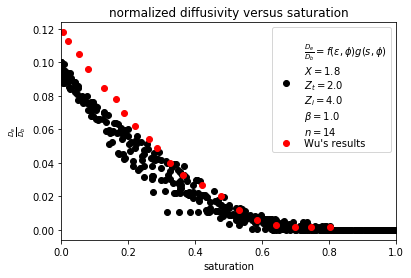

In [10]:
x_values = np.asarray(x_values).flatten()
y_values = np.asarray(y_values).flatten()
plt.figure()
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

wu_average_x_values = [0.004, 0.021, 0.052, 0.081, 0.129, 0.162, 0.186, 0.219, 0.261,
                       0.286, 0.324, 0.363, 0.42, 0.478, 0.531, 0.586, 0.64, 0.698, 0.747, 0.802]
wu_average_y_values = [0.118, 0.113, 0.105, 0.096, 0.085, 0.078, 0.07, 0.062, 0.054, 0.049, 0.04,
                       0.033, 0.027, 0.02, 0.012, 0.006, 0.003, 0.002, 0.002, 0.002]

p1, = plt.plot(x_values, y_values, 'ko')
p2, = plt.plot(wu_average_x_values, wu_average_y_values, 'ro')
plt.title('normalized diffusivity versus saturation')
plt.xlabel('saturation')
plt.ylabel(r'$\frac{D_e}{D_b}$')
#plt.ylim([0, .15])
plt.xlim([0, 1])
plt.legend([p1, p2],
                   [r'$\frac{D_e}{D_b} = f(\epsilon, \phi)g(s, \phi)$' + '\n' + r'$X = 1.8$' +
                   '\n' + r'$Z_t = 2.0$' + '\n' + r'$Z_i = 4.0$' + '\n' + r'$\beta = 1.0$' + '\n' + r'$n = 14$', "Wu's results"])

plt.show()

We can also investigate the effect of network size on the single phase diffusivity

In [11]:
y_2_values = []

n_values = [8, 10, 12, 14, 16, 18, 20]

for x in range(5):
    for n in n_values:
        x_ensemble, y_ensemble = simulation(n=n, npts=1)
        y_2_values.append(y_ensemble)

************************************************************
Running Sim with Net Size = 8 num points 1
************************************************************
Step 0 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 89.41458630847768
Solution converged: 0.0
Step 0 Saturation 0.000 Diffusivity 0.096
************************************************************
Running Sim with Net Size = 10 num points 1
************************************************************
Step 0 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 178.26127873927186
Solution converged: 0.0
Step 0 Saturation 0.000 Diffusivity 0.090
************************************************************
Running Sim with Net Size = 12 num points 1
************************************************************
Step 0 is percolating
――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 1402.4129629469567
Solution converged: 0.0
Step 0 Saturation 0.000 Diffusivity 0.081
************************************************************
Running Sim with Net Size = 8 num points 1
************************************************************
Step 0 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 94.41357907303876
Solution converged: 0.0
Step 0 Saturation 0.000 Diffusivity 0.092
************************************************************
Running Sim with Net Size = 10 num points 1
************************************************************
Step 0 is percolating
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 176.5766506309577
Solution converged: 0.0
Step 0 Saturation 0.000 Diffusivity 

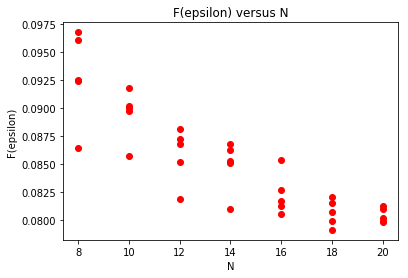

In [12]:
y_2_values = np.asarray(y_2_values).flatten()
plt.figure()
plt.plot(n_values + n_values + n_values + n_values + n_values, y_2_values, 'ro')
plt.title('F(epsilon) versus N')
plt.xlabel('N')
plt.ylabel('F(epsilon)')
#plt.axis(xmin = 6,xmax = 22,ymin= 0,ymax = .2)
plt.show()

And finally extract the g(S) function for relative diffusivity.

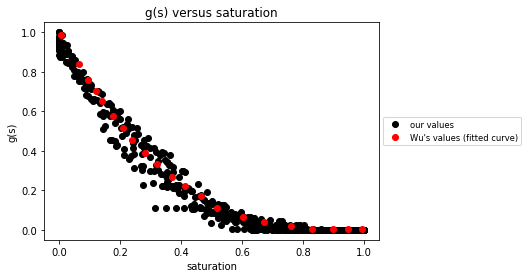

In [13]:
plt.figure()
normalize_factor = max(y_values)
g_values = y_values / normalize_factor

wu_saturation = [0.004, 0.066, 0.0930, .119, 0.14, 0.175, 0.209, 0.24, 0.282, 0.32, 0.371, 0.413,
                 0.464, 0.517, 0.605, 0.672, 0.761, 0.831, 0.898, 0.948, 0.996]
wu_g_values = [0.986, 0.838, 0.758, 0.701, 0.651, 0.576, 0.516, 0.456, 0.39, 0.335, 0.268, 0.221,
               0.171, 0.111, 0.067, 0.04, 0.019, 0.007, 0.003, 0.003, 0.003]

p1, = plt.plot(x_values, g_values, 'ko')
p2, = plt.plot(wu_saturation, wu_g_values, 'ro')
plt.title('g(s) versus saturation')
plt.xlabel('saturation')
plt.ylabel('g(s)')
plt.legend([p1, p2],
                   ["our values", "Wu's values (fitted curve)"], loc='center left', bbox_to_anchor=(1, 0.5), prop = fontP)
plt.show()